In [140]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from src.random_baseline import compute_random_baseline
from models.classical_ml import knn, logistic_regression, random_forest, xgbc, voting_classifier
from src.preprocessing import clean_df, complete_df, prepare_feature_target_matrices

import warnings
warnings.filterwarnings("ignore")

In [142]:
# Load the data under xlsx format
desc = pd.read_excel('data/Descriptif_patients.xlsx')
global_radio = pd.read_excel("data/radiomiques_global.xlsx") # "features" extraits de la segmentation 3D (donc associés à toute la lésion)
multislice = pd.read_excel("data/radiomiques_multislice.xlsx") #  "features" extraits de la segmentation 2D (donc associés à chaque coupe 2D où la lésion est présente)

### Data exploration

In [143]:
# Clean the data
desc_clean, global_radio_clean, multislice_clean = clean_df(desc, global_radio, multislice)

# Ensure only complete records are used
global_radio_complete, multislice_complete = complete_df(global_radio_clean, multislice_clean)

# Prepare feature and target matrices
X, y = prepare_feature_target_matrices(global_radio_complete)

# Outputs to verify
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

X.head()

Shape of X: (117, 432)
Shape of y: (117,)


,ART_original_firstorder_10Percentile,PORT_original_firstorder_10Percentile,VEIN_original_firstorder_10Percentile,TARD_original_firstorder_10Percentile,ART_original_firstorder_90Percentile,PORT_original_firstorder_90Percentile,VEIN_original_firstorder_90Percentile,TARD_original_firstorder_90Percentile,ART_original_firstorder_Energy,PORT_original_firstorder_Energy,...,VEIN_original_ngtdm_Complexity,TARD_original_ngtdm_Complexity,ART_original_ngtdm_Contrast,PORT_original_ngtdm_Contrast,VEIN_original_ngtdm_Contrast,TARD_original_ngtdm_Contrast,ART_original_ngtdm_Strength,PORT_original_ngtdm_Strength,VEIN_original_ngtdm_Strength,TARD_original_ngtdm_Strength
ID,,,,,,,,,,,,,,,,,,,,,
0,211.0,256.0,264.0,253.0,367.0,362.0,359.0,341.0,3.015106e+08,3.356713e+08,...,39.277987,38.563334,0.053328,0.014902,0.015188,0.013078,0.226864,0.534732,0.332041,0.379284
1,260.1,229.0,229.1,212.0,894.0,954.8,1144.7,1120.9,7.323840e+08,7.720563e+08,...,11442.875990,7286.155315,0.312577,0.370738,0.449753,0.514460,5.425102,5.795566,9.512513,6.745733
4,110.0,130.0,134.0,143.0,166.0,171.0,167.0,168.0,1.982289e+07,1.992656e+07,...,1.508313,1.566126,0.018048,0.012486,0.013621,0.009396,0.224467,0.121753,0.061704,0.053781
5,162.7,341.7,333.6,346.4,277.3,445.3,416.7,402.6,4.416506e+06,1.807627e+07,...,13.409998,7.369850,0.118901,0.086435,0.057493,0.086926,1.455775,1.305156,1.083879,0.645670
6,399.0,484.0,496.0,488.0,638.0,671.0,673.0,651.0,1.289387e+10,1.594912e+10,...,596.169662,493.969070,0.036039,0.020776,0.026698,0.024221,0.140786,0.236058,0.187567,0.157278


### Simple ML models

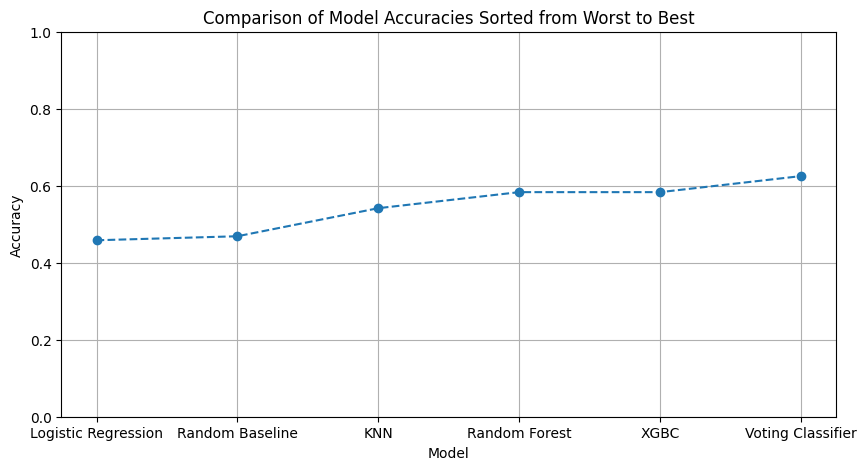

In [144]:
# Encode y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_functions = [logistic_regression, random_forest, xgbc, knn, voting_classifier]
model_names = ["Random Baseline", "Logistic Regression", "Random Forest", "XGBC", "KNN", "Voting Classifier"]
accuracies = [compute_random_baseline(y_test)]

for train_func in model_functions:
    acc = train_func(X_train, y_train, X_test, y_test)
    accuracies.append(acc)


# Sort models by accuracy
sorted_indices = sorted(range(len(accuracies)), key=lambda k: accuracies[k])
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Plotting the results with a line plot and dotted lines
plt.figure(figsize=(10, 5))
plt.plot(sorted_model_names, sorted_accuracies, 'o--')  # 'o--' denotes dotted line with markers
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies Sorted from Worst to Best')
plt.ylim([0, 1])  # Assuming accuracy scores between 0 and 1
plt.grid(True)
plt.show()


### Viz

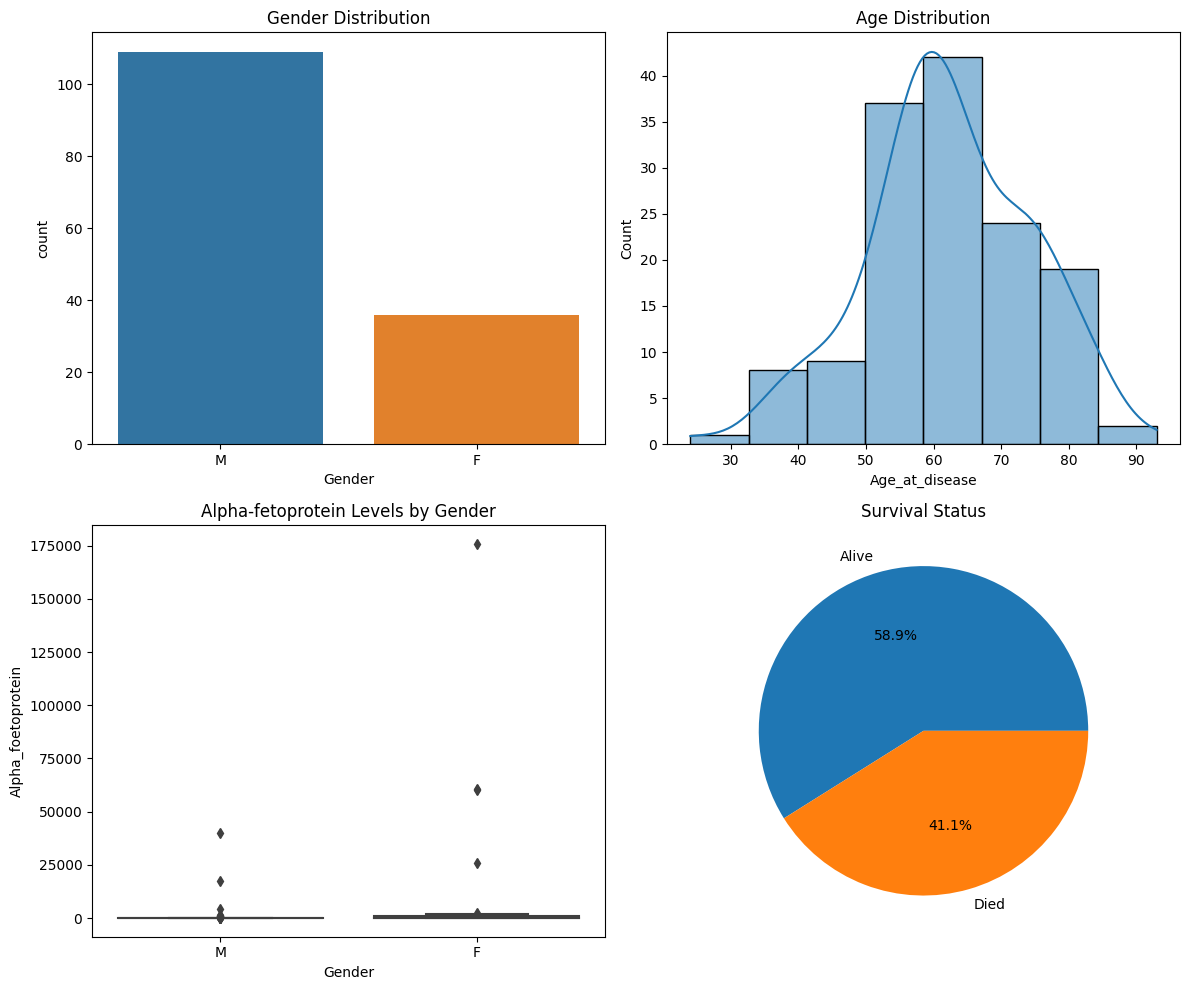

In [29]:
# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Gender Distribution
sns.countplot(x='Gender', data=desc, ax=axes[0, 0])
axes[0, 0].set_title('Gender Distribution')

# Age Distribution
sns.histplot(desc['Age_at_disease'], bins=8, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution')

# Alpha-fetoprotein Levels by Gender
sns.boxplot(x='Gender', y='Alpha_foetoprotein', data=desc, ax=axes[1, 0])
axes[1, 0].set_title('Alpha-fetoprotein Levels by Gender')

# Survival Status
death_counts = desc['Death'].value_counts()
axes[1, 1].pie(death_counts, labels=death_counts.index.map({0: 'Alive', 1: 'Died'}), autopct='%1.1f%%')
axes[1, 1].set_title('Survival Status')

plt.tight_layout()
plt.show()

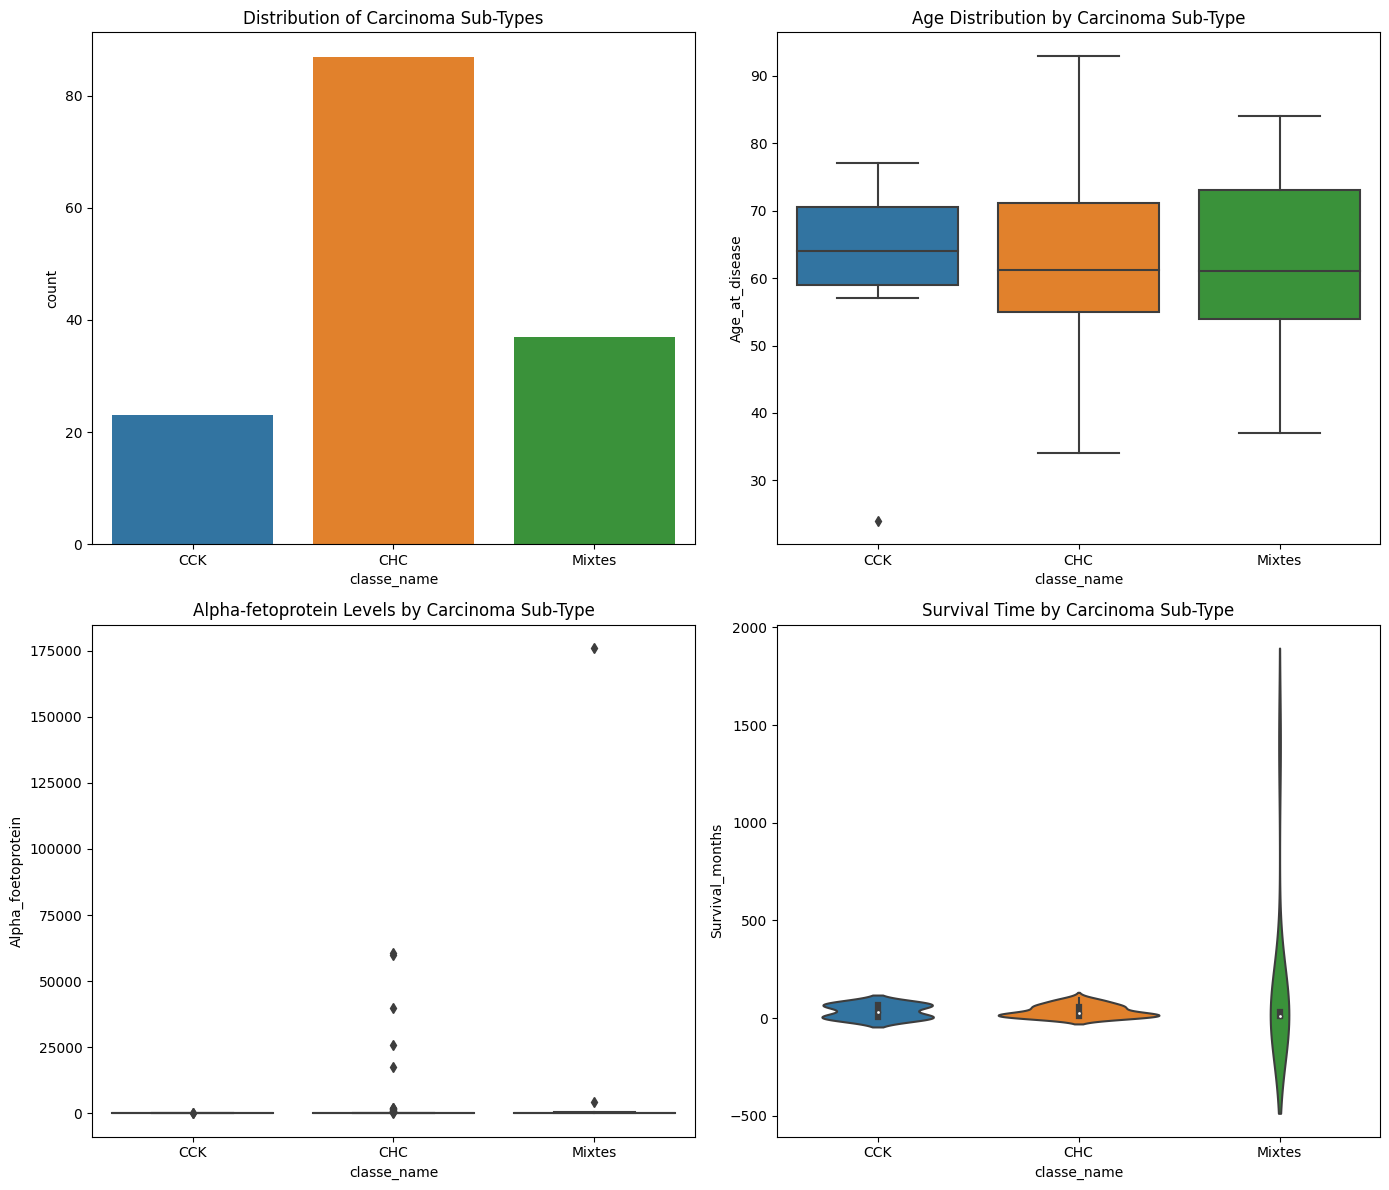

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

# Count of Each Carcinoma Sub-Type
sns.countplot(x='classe_name', data=desc, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Carcinoma Sub-Types')

# Distribution of Age by Carcinoma Sub-Type
sns.boxplot(x='classe_name', y='Age_at_disease', data=desc, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Carcinoma Sub-Type')

# Alpha-fetoprotein Levels by Carcinoma Sub-Type
sns.boxplot(x='classe_name', y='Alpha_foetoprotein', data=desc, ax=axes[1, 0])
axes[1, 0].set_title('Alpha-fetoprotein Levels by Carcinoma Sub-Type')

# Survival Months by Carcinoma Sub-Type
sns.violinplot(x='classe_name', y='Survival_months', data=desc, ax=axes[1, 1])
axes[1, 1].set_title('Survival Time by Carcinoma Sub-Type')

plt.tight_layout()
plt.show()



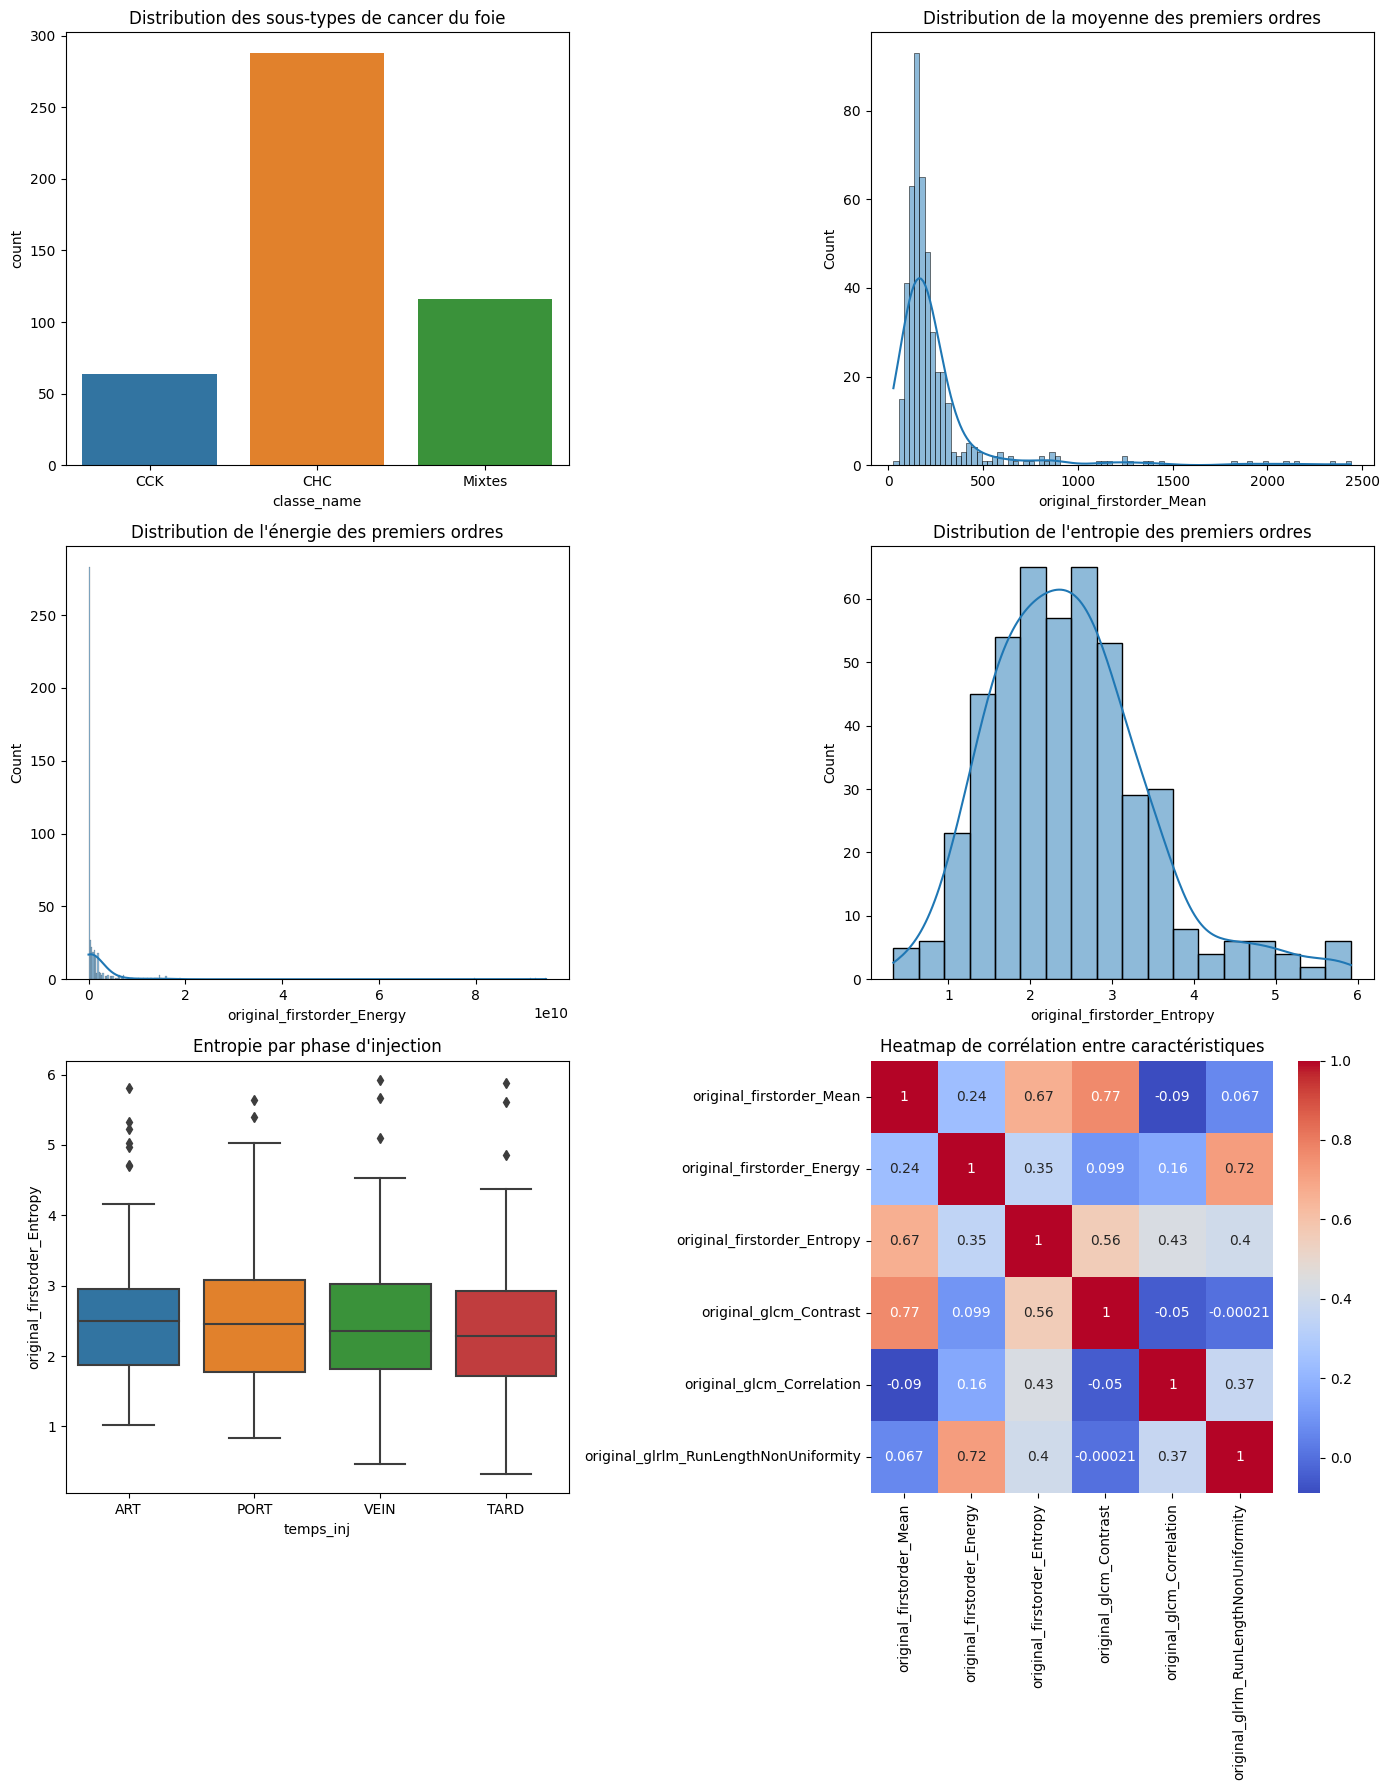

In [31]:
# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))

# Distribution des sous-types de cancer du foie
sns.countplot(x='classe_name', data=global_radio_complete, ax=axes[0, 0])
axes[0, 0].set_title('Distribution des sous-types de cancer du foie')

# Histogrammes pour Mean, Energy, Entropy
sns.histplot(global_radio_complete['original_firstorder_Mean'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution de la moyenne des premiers ordres')

sns.histplot(global_radio_complete['original_firstorder_Energy'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution de l\'énergie des premiers ordres')

sns.histplot(global_radio_complete['original_firstorder_Entropy'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution de l\'entropie des premiers ordres')

# Boxplot pour l'entropie par phase d'injection
sns.boxplot(x='temps_inj', y='original_firstorder_Entropy', data=global_radio_complete, ax=axes[2, 0])
axes[2, 0].set_title('Entropie par phase d\'injection')

# Correlation heatmap for selected features
correlation_features = ['original_firstorder_Mean', 'original_firstorder_Energy', 'original_firstorder_Entropy', 
                        'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glrlm_RunLengthNonUniformity']
corr_matrix = global_radio_complete[correlation_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[2, 1])
axes[2, 1].set_title('Heatmap de corrélation entre caractéristiques')

plt.tight_layout()
plt.show()

### Experiments